Basic imports

In [2]:
#@title [RUN] Import python modules
import os
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#from google.colab import files
from IPython.display import HTML

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

PyTorch version 2.2.2
PyG version 2.0.3


In [3]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(1)

Convert networkx inputs to PyG

In [4]:
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

In [5]:
#train_data = load_data_from_file("/Users/thepoetoftwilight/Documents/ML/gnn/ludwigteam/data/graph_data_duplicates_v2.json") # dictionary of SMILES and values are graphs
train_data = load_data_from_file("graph_data_duplicates_v2.json") # dictionary of SMILES and values are graphs

In [6]:
atom_dict = {
 'H':1,
 'He':2,
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

orb_dict = {
 '1s': [1, 0, 0],
 '2s': [2, 0, 0],
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
    
 '3s': [3, 0, 0],
 '3p': [3, 1, 0],
 '3p3/2': [3, 1, 1.5],
 '3d': [3, 2, 0],
 '3d5/2': [3, 2, 2.5],
    
 '4s': [4, 0, 0],
 '4p3/2': [4, 1, 1.5],
 '4d': [4, 2, 0],
 '4d5/2': [4, 2, 2.5],
 '4f7/2': [4, 3, 3.5],
    
 '5s': [5, 0, 0],
 '5p3/2': [5, 1, 1.5],
 '5d5/2': [5, 2, 2.5],
}

orb_list = list(orb_dict.keys())

bond_dict = {'SINGLE':1, 'DOUBLE':2, 'TRIPLE':3, 'NONE':0}

In [7]:
import pandas as pd

# Lookup table
iso_be_df = pd.read_csv('Isolated_Energy_final.csv')

# Embeddings
embed_df = pd.read_csv('final_embedding_dim30_induced.csv')

In [8]:
# Embedding IDs
embedded_atoms = list(embed_df['Atoms'])

# Embedding vectors
embed_dict = {}

for i in range(len(embed_df)):
    vec = np.fromstring(embed_df.loc[i,'Embeddings'].replace('\n','').strip('[]'), sep=' ')
    embed_dict[embedded_atoms[i]] = vec
        
# Embedding doesn't have entry for H
embed_dict['H'] = np.zeros(30)

In [9]:
dataset = []

for i, mol in enumerate(train_data):
    graph = train_data[mol]
    
    
    # Create node features (# atoms by target, atomic embedding, charge, one-hot encoding for orbital)
    targets = list(nx.get_node_attributes(graph, "target").values())
    x = np.zeros((len(targets), 49))

    # Indicate target atom
    atom_index = targets.index(True)
    x[atom_index, 0] = 1  
    
    # Indicate formal charges
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    x[:, 1] = charge  
    
    # Indicate atom embeddings
    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    embed_mat = np.array([embed_dict[a] for a in atom])
    x[:,2:32] = embed_mat
    
    # One hot encode orbital for target atom
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    x[atom_index, 32 + orb_list.index(orb[atom_index][0])] = 1 
    
    # Make PyG friendly
    x = torch.tensor(x, dtype=torch.float)
    
    # Target value
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())
    y = torch.tensor([energy[atom_index][0]], dtype=torch.float)
    # Isolated binding energy from lookup table (for delta learning)
    be = float(iso_be_df.loc[atom_dict[atom[atom_index]]-1,orb[atom_index][0]]) 
    

    # Fix for edge_index with source and destination nodes
    edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()

    # Encode edge indices
    bond_types = list(nx.get_edge_attributes(graph, "bond_type").values())
    
    # Fix for edge_attr construction
    edge_attr = np.zeros((4, len(bond_types), ))
    
    for j,b in enumerate(bond_types):
        edge_attr[bond_dict[b], j] = 1
    
    edge_attr = torch.tensor(edge_attr, dtype=torch.long).t().contiguous()

    # Then proceed with creating the Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y-be, name=mol, y0=be)
    dataset.append(data)

Data prep and splitting

In [10]:
from torch.utils.data import random_split

print(f"Total number of samples: {len(dataset)}.")

mols = np.array(list(train_data.keys()))
mols = np.array([mol.split('_')[0] for mol in mols]) # there are no underscores in the molecule names

# Get unique molecules and assign unique indices to each
unique_molecules, unique_index = np.unique(mols, return_inverse=True)

print(unique_index.max()) # goes from 0 to 859 for the 860 unique molecules

# Choose a random subset of test molecules
unseen_subset = np.random.choice(np.arange(0, 859), size=200, replace=False) # 100 random molecules

whitelist = ~np.in1d(unique_index, unseen_subset)
train_val_dataset = [dataset[i] for i in range(len(dataset)) if whitelist[i]]
test_dataset = [dataset[i] for i in range(len(dataset)) if not whitelist[i]] # Test dataset is the unseen subset

# Split datasets (our 3K subset)
# Split the dataset into train, validation, and test sets
train_size = int(0.75*len(train_val_dataset))
test_size = len(train_val_dataset)-train_size
split_seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, test_size], generator=split_seed)

print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 5192.
859
Created dataset splits with 3108 training, 1037 validation, 1047 test samples.


### Blueprint of data objects

In [11]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the
        message passing procedure: `message()` -> `aggregate()` -> `update()`.

        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`,
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take
        any arguments that were initially passed to `propagate`. Additionally,
        we can differentiate destination nodes and source nodes by appending
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`.

        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features
            h_j: (e, d) - source node features
            edge_attr: (e, d_e) - edge features

        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        # SK - note how the dimensions of h_i and h_j were recast compared to forward()
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)

    def aggregate(self, inputs, index, ptr=None, dim_size=None):

        """The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        aggr_out = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size, reduce=self.aggr)

        return aggr_out

    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`,
        as well as any optional arguments that were initially passed to
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """

        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [12]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=49, edge_dim=1, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()

        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)

        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))

        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)

    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns:
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)

        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

Load results for val set

In [100]:
num_layers_grid = np.arange(4,11)
emb_dim_grid = np.arange(54,104,10)

In [101]:
val_mae_grid = np.zeros((len(num_layers_grid), len(emb_dim_grid)))

for i in range(len(num_layers_grid)):
    for j in range(len(emb_dim_grid)):
        
        num_layers = num_layers_grid[i]
        emb_dim = emb_dim_grid[j]

        model = MPNNModel(num_layers=num_layers, emb_dim=emb_dim, in_dim=49, edge_dim=4, out_dim=1)
        model.load_state_dict(torch.load('models_MPNN_arch/l{0}_e{1}_model.pth'.format(num_layers, emb_dim), 
                                         map_location=torch.device('cpu')))

        model.eval()

        y_pred_list = []
        y0_list = []
        y_test_list = []


        for data in val_loader:
            data = data.to('cpu')
            with torch.no_grad():
                y_pred = model(data)

                y0_list += list(data.y0)
                y_pred_list = y_pred_list + list(y_pred+data.y0)
                y_test_list = y_test_list + list(data.y+data.y0)

        y0_arr = np.array(y0_list)
        y_pred_arr = np.array(y_pred_list)
        y_test_arr = np.array(y_test_list)

        val_mae_grid[i,j] = np.mean(np.abs(y_pred_arr-y_test_arr))

In [102]:
val_mae_grid.shape

(7, 5)

In [103]:
DF_RESULTS = pd.read_csv('models_MPNN_arch/l6_e64_metrics.csv')

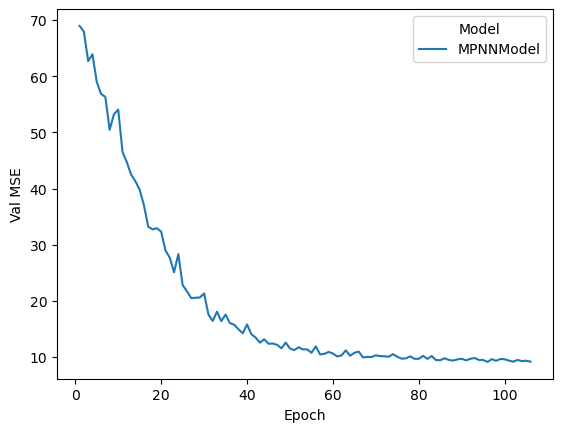

In [104]:
p = sns.lineplot(x="Epoch", y="Val MSE", hue="Model", data=DF_RESULTS)
#p.set(ylim=(0, 2));

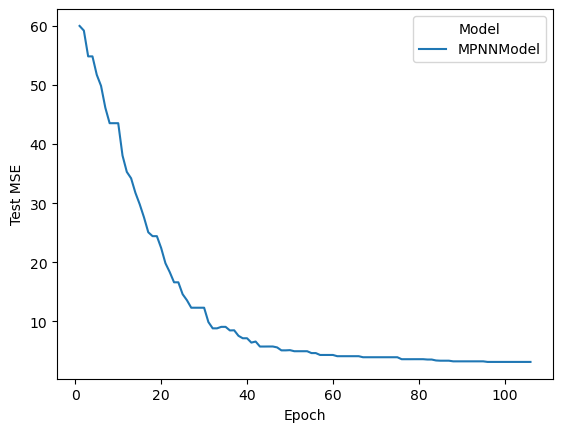

In [105]:
p = sns.lineplot(x="Epoch", y="Test MSE", hue="Model", data=DF_RESULTS)
#p.set(ylim=(0, 1));

In [99]:
val_mae_grid[:,1:].shape

(7, 4)

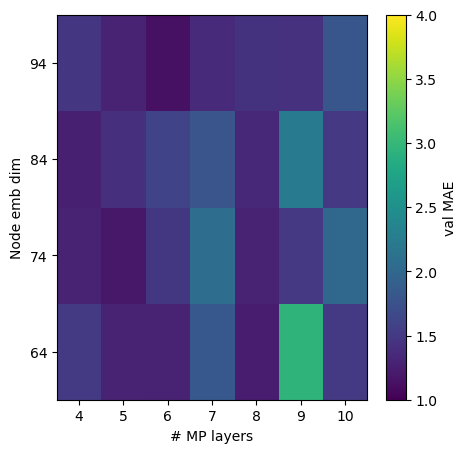

In [112]:
fig, ax = plt.subplots(1, figsize=(5,5))

extent = [num_layers_grid[0]-.5, num_layers_grid[-1]+.5, emb_dim_grid[1]-5, emb_dim_grid[-1]+5]

im = ax.imshow(val_mae_grid[:,1:].T, extent=extent, origin='lower', aspect='auto', interpolation='none',
              vmin=1, vmax=4)

# Calculate the aspect ratio of the extent
#extent_aspect = (extent[1] - extent[0]) / (extent[3] - extent[2])

# Set the aspect ratio of the axes to match the extent
#ax.set_aspect(extent_aspect)

ax.set_xlabel('# MP layers')
ax.set_ylabel('Node emb dim')

ax.set_xticks([4,5,6,7,8,9,10], [4,5,6,7,8,9,10])
ax.set_yticks([64,74,84,94], [64,74,84,94])
#ax.set_yticks([54,64,74,84,94,104], [54,64,74,84,94,104])

plt.colorbar(im, label='val MAE')

In [79]:
min_index_flat = np.argmin(val_mae_grid)
min_index_2d = np.unravel_index(min_index_flat, val_mae_grid.shape)

In [80]:
num_layers_grid[min_index_2d[0]], emb_dim_grid[min_index_2d[1]],

(6, 94)

In [84]:
val_mae_grid = np.zeros((len(num_layers_grid), len(emb_dim_grid)))

for i in range(len(num_layers_grid)):
    for j in range(len(emb_dim_grid)):
        
        num_layers = num_layers_grid[i]
        emb_dim = emb_dim_grid[j]

        model = MPNNModel(num_layers=num_layers, emb_dim=emb_dim, in_dim=49, edge_dim=4, out_dim=1)
        model.load_state_dict(torch.load('models_MPNN_arch/l{0}_e{1}_model.pth'.format(num_layers, emb_dim), 
                                         map_location=torch.device('cpu')))

        model.eval()

        y_pred_list = []
        y0_list = []
        y_test_list = []


        for data in test_loader:
            data = data.to('cpu')
            with torch.no_grad():
                y_pred = model(data)

                y0_list += list(data.y0)
                y_pred_list = y_pred_list + list(y_pred+data.y0)
                y_test_list = y_test_list + list(data.y+data.y0)

        y0_arr = np.array(y0_list)
        y_pred_arr = np.array(y_pred_list)
        y_test_arr = np.array(y_test_list)

        test_mae_grid[i,j] = np.mean(np.abs(y_pred_arr-y_test_arr))

In [86]:
test_mae_grid[min_index_2d]

0.9571771025657654

In [88]:
model = MPNNModel(num_layers=6, emb_dim=94, in_dim=49, edge_dim=4, out_dim=1)
model.load_state_dict(torch.load('models_MPNN_arch/l6_e94_model.pth'.format(num_layers, emb_dim), 
                                 map_location=torch.device('cpu')))

model.eval()

y_pred_list = []
y0_list = []
y_test_list = []


for data in test_loader:
    data = data.to('cpu')
    with torch.no_grad():
        y_pred = model(data)

        y0_list += list(data.y0)
        y_pred_list = y_pred_list + list(y_pred+data.y0)
        y_test_list = y_test_list + list(data.y+data.y0)

y0_arr = np.array(y0_list)
y_pred_arr = np.array(y_pred_list)
y_test_arr = np.array(y_test_list)

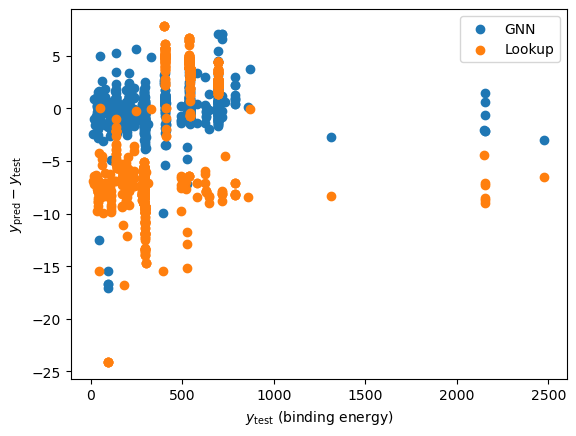

In [89]:
plt.scatter(y_test_arr, y_pred_arr-y_test_arr, label='GNN')
plt.scatter(y_test_arr, y0_arr-y_test_arr, label='Lookup')

plt.xlabel(r'$y_\mathrm{test}$ (binding energy)')
plt.ylabel(r'$y_\mathrm{pred}-y_\mathrm{test}$')

plt.legend()